In [1]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from tqdm import tqdm
import audiomentations
from torch_audiomentations import Compose, PitchShift, TimeInversion, AddBackgroundNoise, AddColoredNoise, PolarityInversion
import torchaudio
import numpy as np
import sys
import matplotlib.pyplot as plt
import tensorboard
from torch.utils.tensorboard import SummaryWriter

WRITER_PATH ="../logs/CNN_L"

# Building the Cough Dataset

This is the preprocessing pipeline for all audio samples in the audio dataset.

In [15]:
# Adapted from https://github.com/musikalkemist/pytorchforaudio

class CoughDataset(Dataset):

    def __init__(self,
                 annotations_df,
                 audio_dir,
                 target_sample_rate,
                 num_samples,
                 device,
                ):
        self.annotations = annotations_df
        self.audio_dir = audio_dir
        self.device = device
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
        self.label_dict = {'healthy':0, 'symptomatic':1, 'COVID-19':1}
        self.label_weights = self._calculate_weights(annotations_df)


    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self.label_dict[self._get_audio_sample_label(index)]
        signal, sr = torchaudio.load(audio_sample_path)
        
        signal = signal.to(self.device)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)

        if "symptomatic" == self._get_audio_sample_label(index):
            raise ValueError

        return signal, label

    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _get_audio_sample_path(self, index):
        path = os.path.join(self.audio_dir, self.annotations.iloc[index, 0])+".wav"
        return path


    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 9]

    def _calculate_weights(self, annotation_df):
        counts = annotation_df["status"].value_counts()
        total = len(annotation_df)
        weights = (1-(counts/total))
        weights /= weights.sum()
        return torch.FloatTensor(weights)

# Oversampled Dataset

In [16]:
AUDIO_DIR = "../valid_data/"
SAMPLE_RATE = 16000
NUM_SAMPLES = SAMPLE_RATE*10

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

train_df = pd.read_parquet(os.path.join(AUDIO_DIR, "train_balanced_3500.parquet.gzip"))
val_df = pd.read_parquet(os.path.join(AUDIO_DIR, "val_balanced_3500.parquet.gzip"))
test_df = pd.read_parquet(os.path.join(AUDIO_DIR, "test_balanced_3500.parquet.gzip"))

# Normal (3 Class) Dataset

In [6]:
AUDIO_DIR = "../valid_data/"
SAMPLE_RATE = 16000
NUM_SAMPLES = SAMPLE_RATE*10

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

train_df = pd.read_parquet(os.path.join(AUDIO_DIR, "train_edited.parquet.gzip"))
val_df = pd.read_parquet(os.path.join(AUDIO_DIR, "val_edited.parquet.gzip"))
test_df = pd.read_parquet(os.path.join(AUDIO_DIR, "test_edited.parquet.gzip"))

# Large CNN Model (161,122 parameters)

In [17]:
class CNNNetwork(torch.nn.Module):

    def __init__(self, drop_p=0.2):
        super().__init__()
        # 4 conv blocks / flatten / linear / softmax
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=2,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(16),
            nn.Dropout(p=drop_p)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=2,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.BatchNorm2d(32),
            nn.Dropout(p=drop_p)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.BatchNorm2d(64),
            nn.Dropout(p=drop_p)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.BatchNorm2d(128),
            nn.Dropout(p=drop_p)
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(31744, 2)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_data):
        #nomralization
        # std = input_data.std()
        # input_data -= input_data.mean()
        # input_data /= std
        
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        logits = self.linear(x)
        predictions = self.softmax(logits)
        return predictions

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score


mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=128
).to(device)

augmentations = Compose(
        transforms=[
            PitchShift(
                mode = "per_example",
                p=0.5,
                sample_rate=SAMPLE_RATE,
                output_type="tensor"
                ),
            TimeInversion(
                mode = "per_example",
                p=0.5,
                output_type="tensor"
            ),
            AddColoredNoise(
                mode = "per_example",
                p=0.5,
                sample_rate=SAMPLE_RATE,
                output_type="tensor"
            ),
            PolarityInversion(
                mode="per_example",
                p=0.5,
                output_type="tensor"
            ), 

        ], output_type="tensor"
    )

def create_data_loader(train_data, batch_size):
    train_dataloader = DataLoader(train_data, batch_size=batch_size)
    print('train_dataloader finished: ', train_dataloader)
    return train_dataloader

def count_correct(logits, y_true):
    y_pred = torch.argmax(logits, axis = 1)
    return torch.sum(y_pred==y_true)

def train_single_epoch(model, train_data_loader, val_data_loader, loss_fn, optimiser, device, do_augment=False):
    total_loss_train = 0.0
    correct_pred_train = 0.0
    total_pred_train = 0

    train_trues = []
    train_preds = []

    for x_batch, y_batch in tqdm(train_data_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        if do_augment:
            x_batch = augmentations(x_batch, SAMPLE_RATE)
        

        x_batch = x_batch.reshape(-1, x_batch.shape[-1])
        x_batch = mel_spectrogram(x_batch)
        x_batch = x_batch.reshape(x_batch.shape[0], 1, x_batch.shape[-2], x_batch.shape[-1])
        
        # calculate loss
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)

        # add to list for f1 score
        train_trues.append(y_batch.cpu())
        train_preds.append(y_pred.cpu())
        
        correct_pred_train += count_correct(y_pred, y_batch)
        total_pred_train += y_batch.shape[0]

        # backpropagate error and update weights
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        total_loss_train += loss.item()

        
        
    print(f"Training loss: {total_loss_train}, Training accuracy : {correct_pred_train/total_pred_train}")
    #print normalized loss
    print(f"Training loss normalized: {total_loss_train/len(train_data_loader)}")
    # print f1 score, precision, recall
    # print(classification_report(torch.cat(train_trues).detach().cpu().numpy(), torch.argmax(torch.cat(train_preds), axis=1).detach().cpu().numpy()))
    
    total_loss_val = 0.0
    correct_pred_val = 0.0
    total_pred_val = 0

    val_trues = []
    val_preds = []

    for x_batch, y_batch in tqdm(val_data_loader):
        with torch.no_grad():
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            x_batch = x_batch.reshape(-1, x_batch.shape[-1])
            x_batch = mel_spectrogram(x_batch)
            x_batch = x_batch.reshape(x_batch.shape[0], 1, x_batch.shape[-2], x_batch.shape[-1])

            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            total_loss_val += loss.item() 
            
            val_trues.append(y_batch.cpu())
            val_preds.append(y_pred.cpu())

        correct_pred_val += count_correct(y_pred, y_batch)
        total_pred_val += y_batch.shape[0]
        
    print(f"Validataion loss: {total_loss_val}, Validation accuracy : {correct_pred_val/total_pred_val}")
    #print normalized loss
    print(f"Validation loss normalized: {total_loss_val/len(val_data_loader)}")
    #print f1 score, confusion matrix and precision, recall using sklearn and true and predicted values
    # print(classification_report(torch.cat(val_trues).detach().cpu().numpy(), torch.argmax(torch.cat(val_preds), axis=1).detach().cpu().numpy()))
    return total_loss_train/len(train_data_loader), correct_pred_train/total_pred_train, total_loss_val/len(val_data_loader), correct_pred_val/total_pred_val


    
def train(model, train_data_loader, val_data_loader, loss_fn, optimiser, device, epochs, do_augment):
    writer = SummaryWriter(WRITER_PATH)
    for i in range(epochs):
        print(f"Epoch {i+1}")
        train_loss, train_acc, val_loss, val_acc = train_single_epoch(model, train_data_loader, val_data_loader, loss_fn, optimiser, device)
        writer.add_scalar("train/accuracy", train_acc, i)
        writer.add_scalar("train/loss", train_loss, i)
        writer.add_scalar("validation/accuracy", val_acc, i)
        writer.add_scalar("validation/loss", val_loss, i)
        
        path = os.path.join(MODEL_FOLDER, f"epoch_{i}.pth")
        torch.save(model.state_dict(), path)
        print(f"Saved at {path}")
        print("---------------------------")
    print("Finished training")
    print("---------------------------")

    
    
def evaluate(model, eval_data_loader, loss_fn, device):
    print("Evaluating model")
    total_loss = 0.0
    correct_pred = 0.0
    total_pred = 0
    for x_batch, y_batch in tqdm(eval_data_loader):
        with torch.no_grad():
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            x_batch = x_batch.reshape(-1, x_batch.shape[-1])
            x_batch = mel_spectrogram(x_batch)
            x_batch = x_batch.reshape(x_batch.shape[0], 1, x_batch.shape[-2], x_batch.shape[-1])

            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)

            correct_pred += count_correct(y_pred, y_batch)
            total_pred += y_batch.shape[0]

            total_loss += loss.item()

    print(f"Evaluation loss: {total_loss}, Evaluation accuracy : {correct_pred/total_pred}")
    # print normalized loss
    print(f"Evaluation loss normalized: {total_loss/len(eval_data_loader)}")
    print("---------------------------")                

In [19]:
BATCH_SIZE = 256
EPOCHS = 50
MODEL_FOLDER = '../models/CNN_L'

train_data = CoughDataset(train_df,
                        AUDIO_DIR,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device,
                        )
print('train data: ', train_data)

val_data = CoughDataset(val_df,
                        AUDIO_DIR,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device)

test_data = CoughDataset(test_df,
                        AUDIO_DIR,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device)

train_dataloader = create_data_loader(train_data, BATCH_SIZE)
val_dataloader = create_data_loader(val_data, BATCH_SIZE)
test_dataloader = create_data_loader(val_data, BATCH_SIZE)

# construct model and assign it to device
model = CNNNetwork().to(device)

# initialise loss funtion + optimiser
#loss_fn = nn.CrossEntropyLoss(weight=train_data.label_weights)
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=1e-5)

train data:  <__main__.CoughDataset object at 0x2992ed600>
train_dataloader finished:  <torch.utils.data.dataloader.DataLoader object at 0x2992ec550>
train_dataloader finished:  <torch.utils.data.dataloader.DataLoader object at 0x1107335b0>
train_dataloader finished:  <torch.utils.data.dataloader.DataLoader object at 0x28e7b9fc0>


In [20]:
train(model, train_dataloader, val_dataloader, loss_fn, optimiser, device, EPOCHS, do_augment=True)

Epoch 1


100%|██████████| 25/25 [01:08<00:00,  2.74s/it]


Training loss: 17.326526939868927, Training accuracy : 0.5343814492225647
Training loss normalized: 0.6930610775947571


100%|██████████| 4/4 [00:09<00:00,  2.27s/it]


Validataion loss: 2.438407063484192, Validation accuracy : 0.7802786827087402
Validation loss normalized: 0.609601765871048
Saved at ../models/epoch_0.pth
---------------------------
Epoch 2


100%|██████████| 25/25 [01:04<00:00,  2.56s/it]


Training loss: 17.155836403369904, Training accuracy : 0.545656681060791
Training loss normalized: 0.6862334561347961


100%|██████████| 4/4 [00:07<00:00,  1.95s/it]


Validataion loss: 2.5153212547302246, Validation accuracy : 0.7749196290969849
Validation loss normalized: 0.6288303136825562
Saved at ../models/epoch_1.pth
---------------------------
Epoch 3


100%|██████████| 25/25 [01:01<00:00,  2.45s/it]


Training loss: 17.081384778022766, Training accuracy : 0.553438127040863
Training loss normalized: 0.6832553911209106


100%|██████████| 4/4 [00:07<00:00,  1.98s/it]


Validataion loss: 2.4863515496253967, Validation accuracy : 0.7813504934310913
Validation loss normalized: 0.6215878874063492
Saved at ../models/epoch_2.pth
---------------------------
Epoch 4


100%|██████████| 25/25 [01:03<00:00,  2.53s/it]


Training loss: 17.0481778383255, Training accuracy : 0.5508972406387329
Training loss normalized: 0.68192711353302


100%|██████████| 4/4 [00:09<00:00,  2.27s/it]


Validataion loss: 2.462101399898529, Validation accuracy : 0.7824223041534424
Validation loss normalized: 0.6155253499746323
Saved at ../models/epoch_3.pth
---------------------------
Epoch 5


100%|██████████| 25/25 [01:07<00:00,  2.71s/it]


Training loss: 16.939356923103333, Training accuracy : 0.5674130320549011
Training loss normalized: 0.6775742769241333


100%|██████████| 4/4 [00:08<00:00,  2.17s/it]


Validataion loss: 2.457844376564026, Validation accuracy : 0.7802786827087402
Validation loss normalized: 0.6144610941410065
Saved at ../models/epoch_4.pth
---------------------------
Epoch 6


100%|██████████| 25/25 [01:04<00:00,  2.59s/it]


Training loss: 16.794385075569153, Training accuracy : 0.5764650106430054
Training loss normalized: 0.6717754030227661


100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Validataion loss: 2.4888468980789185, Validation accuracy : 0.7609860897064209
Validation loss normalized: 0.6222117245197296
Saved at ../models/epoch_5.pth
---------------------------
Epoch 7


100%|██████████| 25/25 [00:59<00:00,  2.36s/it]


Training loss: 16.74985247850418, Training accuracy : 0.5799587368965149
Training loss normalized: 0.6699940991401673


100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Validataion loss: 2.47118479013443, Validation accuracy : 0.7813504934310913
Validation loss normalized: 0.6177961975336075
Saved at ../models/epoch_6.pth
---------------------------
Epoch 8


100%|██████████| 25/25 [00:59<00:00,  2.40s/it]


Training loss: 16.772924840450287, Training accuracy : 0.5790058970451355
Training loss normalized: 0.6709169936180115


100%|██████████| 4/4 [00:07<00:00,  1.86s/it]


Validataion loss: 2.476702868938446, Validation accuracy : 0.7524116039276123
Validation loss normalized: 0.6191757172346115
Saved at ../models/epoch_7.pth
---------------------------
Epoch 9


100%|██████████| 25/25 [01:02<00:00,  2.50s/it]


Training loss: 16.620672166347504, Training accuracy : 0.5842464566230774
Training loss normalized: 0.6648268866539001


100%|██████████| 4/4 [00:07<00:00,  1.98s/it]


Validataion loss: 2.430899143218994, Validation accuracy : 0.762057900428772
Validation loss normalized: 0.6077247858047485
Saved at ../models/epoch_8.pth
---------------------------
Epoch 10


100%|██████████| 25/25 [01:03<00:00,  2.54s/it]


Training loss: 16.614269733428955, Training accuracy : 0.588057816028595
Training loss normalized: 0.6645707893371582


100%|██████████| 4/4 [00:07<00:00,  1.96s/it]


Validataion loss: 2.4749640226364136, Validation accuracy : 0.7491961121559143
Validation loss normalized: 0.6187410056591034
Saved at ../models/epoch_9.pth
---------------------------
Epoch 11


100%|██████████| 25/25 [01:01<00:00,  2.44s/it]


Training loss: 16.597583889961243, Training accuracy : 0.5904399156570435
Training loss normalized: 0.6639033555984497


100%|██████████| 4/4 [00:07<00:00,  1.97s/it]


Validataion loss: 2.48565012216568, Validation accuracy : 0.7491961121559143
Validation loss normalized: 0.62141253054142
Saved at ../models/epoch_10.pth
---------------------------
Epoch 12


100%|██████████| 25/25 [01:02<00:00,  2.50s/it]


Training loss: 16.53191214799881, Training accuracy : 0.5923455357551575
Training loss normalized: 0.6612764859199524


100%|██████████| 4/4 [00:08<00:00,  2.04s/it]


Validataion loss: 2.486091732978821, Validation accuracy : 0.7384780049324036
Validation loss normalized: 0.6215229332447052
Saved at ../models/epoch_11.pth
---------------------------
Epoch 13


100%|██████████| 25/25 [01:01<00:00,  2.45s/it]


Training loss: 16.502986907958984, Training accuracy : 0.5952040553092957
Training loss normalized: 0.6601194763183593


100%|██████████| 4/4 [00:08<00:00,  2.10s/it]


Validataion loss: 2.4951884150505066, Validation accuracy : 0.7363343834877014
Validation loss normalized: 0.6237971037626266
Saved at ../models/epoch_12.pth
---------------------------
Epoch 14


100%|██████████| 25/25 [01:02<00:00,  2.50s/it]


Training loss: 16.4385786652565, Training accuracy : 0.6036207675933838
Training loss normalized: 0.65754314661026


100%|██████████| 4/4 [00:08<00:00,  2.05s/it]


Validataion loss: 2.4832030534744263, Validation accuracy : 0.7266880869865417
Validation loss normalized: 0.6208007633686066
Saved at ../models/epoch_13.pth
---------------------------
Epoch 15


100%|██████████| 25/25 [01:02<00:00,  2.51s/it]


Training loss: 16.350029051303864, Training accuracy : 0.6133079528808594
Training loss normalized: 0.6540011620521545


100%|██████████| 4/4 [00:07<00:00,  1.99s/it]


Validataion loss: 2.4513246417045593, Validation accuracy : 0.7534834146499634
Validation loss normalized: 0.6128311604261398
Saved at ../models/epoch_14.pth
---------------------------
Epoch 16


100%|██████████| 25/25 [01:02<00:00,  2.52s/it]


Training loss: 16.29741770029068, Training accuracy : 0.6136255264282227
Training loss normalized: 0.6518967080116272


100%|██████████| 4/4 [00:08<00:00,  2.02s/it]


Validataion loss: 2.4570180773735046, Validation accuracy : 0.7524116039276123
Validation loss normalized: 0.6142545193433762
Saved at ../models/epoch_15.pth
---------------------------
Epoch 17


100%|██████████| 25/25 [01:04<00:00,  2.57s/it]


Training loss: 16.247251570224762, Training accuracy : 0.6188661456108093
Training loss normalized: 0.6498900628089905


100%|██████████| 4/4 [00:07<00:00,  2.00s/it]


Validataion loss: 2.4677597880363464, Validation accuracy : 0.7245444655418396
Validation loss normalized: 0.6169399470090866
Saved at ../models/epoch_16.pth
---------------------------
Epoch 18


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


Training loss: 16.235713183879852, Training accuracy : 0.6196601390838623
Training loss normalized: 0.6494285273551941


100%|██████████| 4/4 [00:09<00:00,  2.40s/it]


Validataion loss: 2.4471315741539, Validation accuracy : 0.74490886926651
Validation loss normalized: 0.611782893538475
Saved at ../models/epoch_17.pth
---------------------------
Epoch 19


100%|██████████| 25/25 [01:07<00:00,  2.70s/it]


Training loss: 16.17150241136551, Training accuracy : 0.6228362917900085
Training loss normalized: 0.6468600964546204


100%|██████████| 4/4 [00:09<00:00,  2.26s/it]


Validataion loss: 2.476721704006195, Validation accuracy : 0.7406216263771057
Validation loss normalized: 0.6191804260015488
Saved at ../models/epoch_18.pth
---------------------------
Epoch 20


100%|██████████| 25/25 [01:14<00:00,  2.99s/it]


Training loss: 16.09557592868805, Training accuracy : 0.63157057762146
Training loss normalized: 0.643823037147522


100%|██████████| 4/4 [00:08<00:00,  2.14s/it]


Validataion loss: 2.4240715503692627, Validation accuracy : 0.7459806799888611
Validation loss normalized: 0.6060178875923157
Saved at ../models/epoch_19.pth
---------------------------
Epoch 21


100%|██████████| 25/25 [01:09<00:00,  2.78s/it]


Training loss: 16.055081844329834, Training accuracy : 0.6334762573242188
Training loss normalized: 0.6422032737731933


100%|██████████| 4/4 [00:08<00:00,  2.22s/it]


Validataion loss: 2.4626654982566833, Validation accuracy : 0.730975329875946
Validation loss normalized: 0.6156663745641708
Saved at ../models/epoch_20.pth
---------------------------
Epoch 22


100%|██████████| 25/25 [01:09<00:00,  2.77s/it]


Training loss: 16.074809730052948, Training accuracy : 0.6253771781921387
Training loss normalized: 0.6429923892021179


100%|██████████| 4/4 [00:09<00:00,  2.33s/it]


Validataion loss: 2.479572892189026, Validation accuracy : 0.715969979763031
Validation loss normalized: 0.6198932230472565
Saved at ../models/epoch_21.pth
---------------------------
Epoch 23


100%|██████████| 25/25 [01:10<00:00,  2.81s/it]


Training loss: 16.01108878850937, Training accuracy : 0.637764036655426
Training loss normalized: 0.6404435515403748


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Validataion loss: 2.468004882335663, Validation accuracy : 0.7031082510948181
Validation loss normalized: 0.6170012205839157
Saved at ../models/epoch_22.pth
---------------------------
Epoch 24


100%|██████████| 25/25 [01:07<00:00,  2.72s/it]


Training loss: 15.93074083328247, Training accuracy : 0.6399872899055481
Training loss normalized: 0.6372296333312988


100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


Validataion loss: 2.460698127746582, Validation accuracy : 0.7256162762641907
Validation loss normalized: 0.6151745319366455
Saved at ../models/epoch_23.pth
---------------------------
Epoch 25


100%|██████████| 25/25 [01:04<00:00,  2.58s/it]


Training loss: 15.8390092253685, Training accuracy : 0.6480863690376282
Training loss normalized: 0.63356036901474


100%|██████████| 4/4 [00:08<00:00,  2.04s/it]


Validataion loss: 2.4833864569664, Validation accuracy : 0.6998928189277649
Validation loss normalized: 0.6208466142416
Saved at ../models/epoch_24.pth
---------------------------
Epoch 26


100%|██████████| 25/25 [01:05<00:00,  2.60s/it]


Training loss: 15.899533450603485, Training accuracy : 0.6412577629089355
Training loss normalized: 0.6359813380241394


100%|██████████| 4/4 [00:08<00:00,  2.17s/it]


Validataion loss: 2.4389607310295105, Validation accuracy : 0.7181136012077332
Validation loss normalized: 0.6097401827573776
Saved at ../models/epoch_25.pth
---------------------------
Epoch 27


100%|██████████| 25/25 [01:04<00:00,  2.58s/it]


Training loss: 15.883294641971588, Training accuracy : 0.6436398029327393
Training loss normalized: 0.6353317856788635


100%|██████████| 4/4 [00:08<00:00,  2.08s/it]


Validataion loss: 2.467546761035919, Validation accuracy : 0.7245444655418396
Validation loss normalized: 0.6168866902589798
Saved at ../models/epoch_26.pth
---------------------------
Epoch 28


100%|██████████| 25/25 [01:04<00:00,  2.59s/it]


Training loss: 15.857482194900513, Training accuracy : 0.6417341828346252
Training loss normalized: 0.6342992877960205


100%|██████████| 4/4 [00:08<00:00,  2.25s/it]


Validataion loss: 2.4535791277885437, Validation accuracy : 0.7116827368736267
Validation loss normalized: 0.6133947819471359
Saved at ../models/epoch_27.pth
---------------------------
Epoch 29


100%|██████████| 25/25 [01:05<00:00,  2.61s/it]


Training loss: 15.812575101852417, Training accuracy : 0.6563442945480347
Training loss normalized: 0.6325030040740967


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


Validataion loss: 2.447933256626129, Validation accuracy : 0.7148981690406799
Validation loss normalized: 0.6119833141565323
Saved at ../models/epoch_28.pth
---------------------------
Epoch 30


100%|██████████| 25/25 [01:04<00:00,  2.59s/it]


Training loss: 15.740790784358978, Training accuracy : 0.6530093550682068
Training loss normalized: 0.6296316313743592


100%|██████████| 4/4 [00:08<00:00,  2.19s/it]


Validataion loss: 2.4585883617401123, Validation accuracy : 0.7181136012077332
Validation loss normalized: 0.6146470904350281
Saved at ../models/epoch_29.pth
---------------------------
Epoch 31


100%|██████████| 25/25 [01:07<00:00,  2.69s/it]


Training loss: 15.74034434556961, Training accuracy : 0.6525329351425171
Training loss normalized: 0.6296137738227844


100%|██████████| 4/4 [00:08<00:00,  2.18s/it]


Validataion loss: 2.4761703610420227, Validation accuracy : 0.7063236832618713
Validation loss normalized: 0.6190425902605057
Saved at ../models/epoch_30.pth
---------------------------
Epoch 32


100%|██████████| 25/25 [01:06<00:00,  2.65s/it]


Training loss: 15.624811470508575, Training accuracy : 0.662855327129364
Training loss normalized: 0.624992458820343


100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


Validataion loss: 2.471164882183075, Validation accuracy : 0.6998928189277649
Validation loss normalized: 0.6177912205457687
Saved at ../models/epoch_31.pth
---------------------------
Epoch 33


100%|██████████| 25/25 [01:13<00:00,  2.94s/it]


Training loss: 15.597749471664429, Training accuracy : 0.6666666865348816
Training loss normalized: 0.6239099788665772


100%|██████████| 4/4 [00:08<00:00,  2.17s/it]


Validataion loss: 2.471957504749298, Validation accuracy : 0.7073954939842224
Validation loss normalized: 0.6179893761873245
Saved at ../models/epoch_32.pth
---------------------------
Epoch 34


100%|██████████| 25/25 [01:06<00:00,  2.65s/it]


Training loss: 15.620964288711548, Training accuracy : 0.662855327129364
Training loss normalized: 0.6248385715484619


100%|██████████| 4/4 [00:08<00:00,  2.20s/it]


Validataion loss: 2.456868290901184, Validation accuracy : 0.7095391154289246
Validation loss normalized: 0.614217072725296
Saved at ../models/epoch_33.pth
---------------------------
Epoch 35


100%|██████████| 25/25 [01:04<00:00,  2.59s/it]


Training loss: 15.53894555568695, Training accuracy : 0.6688899397850037
Training loss normalized: 0.621557822227478


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


Validataion loss: 2.509961187839508, Validation accuracy : 0.6795284152030945
Validation loss normalized: 0.627490296959877
Saved at ../models/epoch_34.pth
---------------------------
Epoch 36


100%|██████████| 25/25 [01:06<00:00,  2.67s/it]


Training loss: 15.553757548332214, Training accuracy : 0.6682547330856323
Training loss normalized: 0.6221503019332886


100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


Validataion loss: 2.4553728103637695, Validation accuracy : 0.7170417904853821
Validation loss normalized: 0.6138432025909424
Saved at ../models/epoch_35.pth
---------------------------
Epoch 37


100%|██████████| 25/25 [01:06<00:00,  2.67s/it]


Training loss: 15.533860445022583, Training accuracy : 0.668413519859314
Training loss normalized: 0.6213544178009033


100%|██████████| 4/4 [00:08<00:00,  2.14s/it]


Validataion loss: 2.470486283302307, Validation accuracy : 0.6881029009819031
Validation loss normalized: 0.6176215708255768
Saved at ../models/epoch_36.pth
---------------------------
Epoch 38


100%|██████████| 25/25 [01:11<00:00,  2.87s/it]


Training loss: 15.506269037723541, Training accuracy : 0.6671431064605713
Training loss normalized: 0.6202507615089417


100%|██████████| 4/4 [00:08<00:00,  2.21s/it]


Validataion loss: 2.4726964831352234, Validation accuracy : 0.6923901438713074
Validation loss normalized: 0.6181741207838058
Saved at ../models/epoch_37.pth
---------------------------
Epoch 39


100%|██████████| 25/25 [01:12<00:00,  2.89s/it]


Training loss: 15.459669530391693, Training accuracy : 0.6715896725654602
Training loss normalized: 0.6183867812156677


100%|██████████| 4/4 [00:09<00:00,  2.25s/it]


Validataion loss: 2.439192831516266, Validation accuracy : 0.7245444655418396
Validation loss normalized: 0.6097982078790665
Saved at ../models/epoch_38.pth
---------------------------
Epoch 40


100%|██████████| 25/25 [01:07<00:00,  2.71s/it]


Training loss: 15.433335959911346, Training accuracy : 0.6722248792648315
Training loss normalized: 0.6173334383964538


100%|██████████| 4/4 [00:09<00:00,  2.26s/it]


Validataion loss: 2.4128360748291016, Validation accuracy : 0.7138263583183289
Validation loss normalized: 0.6032090187072754
Saved at ../models/epoch_39.pth
---------------------------
Epoch 41


100%|██████████| 25/25 [01:09<00:00,  2.78s/it]


Training loss: 15.379124104976654, Training accuracy : 0.6817532181739807
Training loss normalized: 0.6151649641990662


100%|██████████| 4/4 [00:08<00:00,  2.14s/it]


Validataion loss: 2.4924609065055847, Validation accuracy : 0.6913183331489563
Validation loss normalized: 0.6231152266263962
Saved at ../models/epoch_40.pth
---------------------------
Epoch 42


100%|██████████| 25/25 [01:07<00:00,  2.68s/it]


Training loss: 15.281673192977905, Training accuracy : 0.6850881576538086
Training loss normalized: 0.6112669277191162


100%|██████████| 4/4 [00:09<00:00,  2.32s/it]


Validataion loss: 2.4701210260391235, Validation accuracy : 0.6784566044807434
Validation loss normalized: 0.6175302565097809
Saved at ../models/epoch_41.pth
---------------------------
Epoch 43


100%|██████████| 25/25 [01:10<00:00,  2.81s/it]


Training loss: 15.227007865905762, Training accuracy : 0.6884230375289917
Training loss normalized: 0.6090803146362305


100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


Validataion loss: 2.4483219385147095, Validation accuracy : 0.6956055760383606
Validation loss normalized: 0.6120804846286774
Saved at ../models/epoch_42.pth
---------------------------
Epoch 44


100%|██████████| 25/25 [01:10<00:00,  2.82s/it]


Training loss: 15.25860857963562, Training accuracy : 0.6831824779510498
Training loss normalized: 0.6103443431854249


100%|██████████| 4/4 [00:08<00:00,  2.16s/it]


Validataion loss: 2.4257694482803345, Validation accuracy : 0.7202572226524353
Validation loss normalized: 0.6064423620700836
Saved at ../models/epoch_43.pth
---------------------------
Epoch 45


 28%|██▊       | 7/25 [00:20<00:51,  2.89s/it]


KeyboardInterrupt: 

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import numpy as np

#set model to be the epoch 10 model in the models folder
model.load_state_dict(torch.load('../models/epoch_43.pth'))

# evaluate model with test data using the loaded model
trues, preds = evaluate(model, test_dataloader, loss_fn, device)


Evaluating model


100%|██████████| 4/4 [00:08<00:00,  2.23s/it]

Evaluation loss: 2.4710311889648438, Evaluation accuracy : 0.6934619545936584
Evaluation loss normalized: 0.6177577972412109
---------------------------


TypeError: cannot unpack non-iterable NoneType object

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import numpy as np

In [24]:
from sklearn.metrics import plot_confusion_matrix

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=128
)

def evaluate_confusion(model, eval_data_loader, device):
    trues = []
    preds =[]
    for x_batch, y_batch in tqdm(eval_data_loader):
        with torch.no_grad():
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            x_batch = x_batch.reshape(-1, x_batch.shape[-1])
            x_batch = mel_spectrogram(x_batch)
            x_batch = x_batch.reshape(x_batch.shape[0], 1, x_batch.shape[-2], x_batch.shape[-1])
            
            y_pred = model(x_batch)

            trues += torch.clamp(y_batch, max=1)
            preds += torch.clamp(torch.argmax(y_pred, axis = 1), max=1)            
            
    return np.array(trues), np.array(preds)

In [25]:
trues, preds = evaluate_confusion(model, test_dataloader, device)

100%|██████████| 4/4 [00:08<00:00,  2.24s/it]


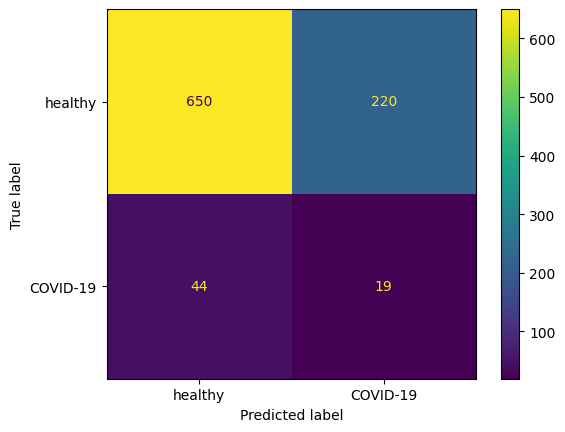

In [26]:
cfm = confusion_matrix(trues, preds)
ConfusionMatrixDisplay(cfm, display_labels=['healthy', 'COVID-19']).plot()

              precision    recall  f1-score   support

           0       0.94      0.75      0.83       870
           1       0.08      0.30      0.13        63

    accuracy                           0.72       933
   macro avg       0.51      0.52      0.48       933
weighted avg       0.88      0.72      0.78       933

f1:  0.478514930302671
roc:  0.5243568691844553


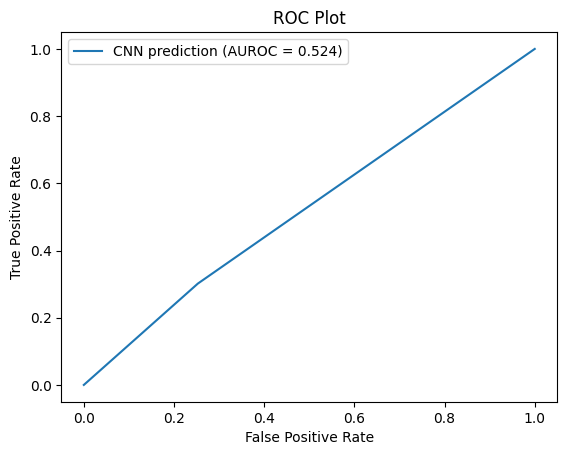

In [27]:
# print classification report
from sklearn.metrics import classification_report
print(classification_report(trues, preds))

# calculate f1 score
from sklearn.metrics import f1_score
print('f1: ', f1_score(trues, preds, average='macro'))

#calculate and graph ROC AUC
from sklearn.metrics import roc_auc_score, plot_roc_curve, roc_curve
r_auc = roc_auc_score(trues, preds)
print('roc: ', r_auc)

fpr, tpr, thresholds = roc_curve(trues, preds)
plt.plot(fpr, tpr, label='CNN prediction (AUROC = %0.3f)' % r_auc)
plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()